In [1]:
import os
import time
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from time import perf_counter
from IPython.display import clear_output
from pathlib import Path

from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds

from tqdm.notebook import tqdm
import datetime




%matplotlib inline

%load_ext autoreload
%autoreload 2


from utils.svm import DCFilter
from utils.visualize import VisulaizeCell, showMe
from utils.record import getRange, stat, preProcess, GenerateOrder

C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [10]:
session = 2
subject = 'Nemes'
res_dir = 'C:/resources/EMG/'+datetime.datetime.now().strftime("%m_%d")+'/session_'+str(session)+'/'
res_dir = os.path.join('C:/resources/EMG',subject,'session_'+str(session))+'/'
print(f'Creating directory {res_dir}...')
Path(res_dir).mkdir( parents=True, exist_ok=False )


Creating directory C:/resources/EMG\Nemes\session_2/...


FileExistsError: [WinError 183] Nem lehet fájlt létrehozni, ha az adott fájl már létezik: 'C:\\resources\\EMG\\Nemes\\session_2'

In [3]:
####      INIT BOARD        #######
BoardShim.enable_dev_board_logger()
params = BrainFlowInputParams()
board = BoardShim(BoardIds.MINDROVE_WIFI_BOARD, params)

try:
    board.stop_stream()
    board.release_session()
except:
    ...
    
board.prepare_session()
sample_rate = board.get_sampling_rate(16)
print("Device ready (sampling rate: {}hz)".format(sample_rate))

Device ready (sampling rate: 500hz)


In [4]:
length_of_signal = 1 #seconds
num_points = int(sample_rate * length_of_signal)
record_length = int(sample_rate * length_of_signal*3)
std_threshold = 200

PRACTICE

In [3]:
def Practice(classes = ['Eyebrow','Smile', 'Chew'],n_samples_per_class = 1):
    classes = ['Rest'] + classes
    results = [[] for i in range(len(classes))]
    tasks = GenerateOrder(len(classes),n_samples_per_class)
  

    print("Setting up...")
    time.sleep(2)          # wait for the board to settle
    for i, task in enumerate(tasks):
        clear_output()
        print("Stand By! ({}/{})".format(i+1,len(tasks)))
        time.sleep(0.5)
        print("Perform |{:^10s}|".format(classes[tasks[i]]))
        time.sleep(2.5)
        
Practice(n_samples_per_class=5)  #30 -> 5min   60 -> 12min 

Stand By! (20/20)
Perform | Eyebrow  |


RECORD

In [5]:
def CollectData(classes = ['Eyebrow','Smile', 'Chew'],n_samples_per_class = 1):
    classes = ['Rest'] + classes
    results = [[] for i in range(len(classes))]
    tasks = GenerateOrder(len(classes),n_samples_per_class)
  
    board.start_stream(450000) 
    print("Setting up...")
    time.sleep(10)          # wait for the board to settle
    for i, task in enumerate(tasks):
        clear_output()
        print("Stand By! ({}/{})".format(i+1,len(tasks)))
        time.sleep(0.5)
        print("Perform |{:^10s}|".format(classes[tasks[i]]))
        time.sleep(2.5)
        data = board.get_current_board_data(sample_rate*60) #1min
       
        data = DCFilter(data)
        data = data[:6,-record_length:] #keep the data of the eeg channels only, and remove data over the trial length
        _, _, std = stat(data)
        if std == 0:
            print("[ERROR] No data collected!")
            break
        results[task].append(data)

    return results, classes
        
results, classes = CollectData(n_samples_per_class=25)  #30 -> 5min   60 -> 12min 

Stand By! (100/100)
Perform |  Smile   |


In [6]:
#Save results to file
i = 0
for result in tqdm(results):
    Path(res_dir).mkdir( parents=True, exist_ok=True )

    result= np.asarray(result)
    np.save(res_dir+classes[i]+"_3s",result)
    i+=1

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
## Show the first N samples of each class
limit = 3
for i, category in enumerate(results):
    print(classes[i])
    for i, record_3s in enumerate(category):
        VisulaizeCell(record_3s, std_threshold)
        print(stat(record_3s))
        if i >= limit:
            break

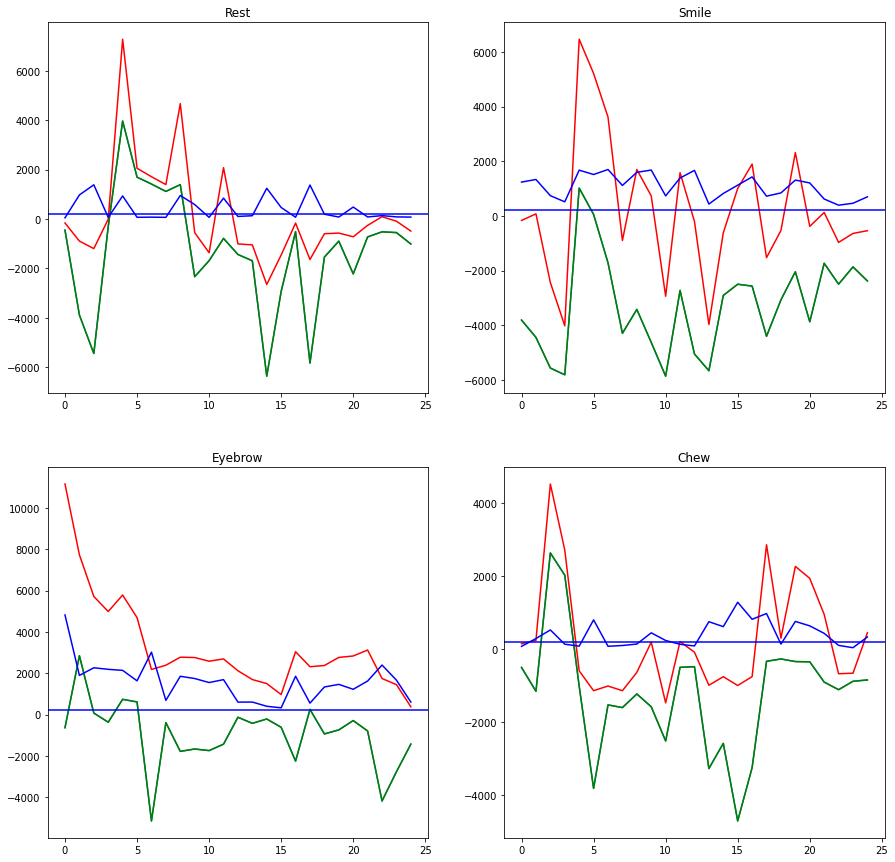

In [7]:
# Check the data quality
from matplotlib.pyplot import figure

fig, axs = plt.subplots(2, 2,figsize=(15,15))



for i, category in enumerate(results):
    class_min = []
    class_max = []
    class_std = []
    for j, record_3s in enumerate(category):
        min, max, std = stat(record_3s)
        class_min.append(min)
        class_max.append(max)
        class_std.append(std)

    axs[i%2,i//2].title.set_text(classes[i])
    axs[i%2,i//2].plot(class_min, label='min')    
    axs[i%2,i//2].plot(class_min,color='green',label='min')
    axs[i%2,i//2].plot(class_max, color = 'red',label='max')
    axs[i%2,i//2].plot(class_std, color = 'blue',label='std')
    axs[i%2,i//2].axhline(y = std_threshold, color = 'b', linestyle = '-')


#plt.show()


In [8]:
## Cut the relevatn 1 sec of the 3 sec trial
## Based on the std of the signal
augment = True
clip_value = 2000


for i, category in enumerate(results):
    print(f'Saving {classes[i]}...')
    temp = []
    for j, record_3s in enumerate(category):
        start, end= getRange(record_3s,std_threshold)
        sample = record_3s[:,start:end]
        temp.append(preProcess(sample, clip_value))
        if augment:
            slice = int(sample_rate/10)

            sample = record_3s[:,start-slice:end-slice]
            temp.append(preProcess(sample, clip_value))

            sample = record_3s[:,start+slice:end+slice]
            temp.append(preProcess(sample, clip_value))

    np.save(res_dir+classes[i]+'_1s_augmented',temp)


Saving Rest...
Saving Eyebrow...
Saving Smile...
Saving Chew...
